In [1]:
import random
import time
import re
import pickle
import os
import string
from typing import Dict
import html

import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
sns.set()

# Pre processing

## keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
## nltk
import nltk
from nltk.corpus import words, stopwords
from nltk.stem import SnowballStemmer, WordNetLemmatizer, PorterStemmer
from nltk.tokenize import word_tokenize, wordpunct_tokenize, RegexpTokenizer

nltk.download('omw-1.4')
nltk.download('punkt')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
from urllib.parse import urljoin

In [3]:
RAW_PATH = 'data/1_raw/'
TOOLS_PATH = 'data/tools/'

In [4]:
DATASET_COLUMNS = ["label", "id", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"

df = pd.read_csv(RAW_PATH + 'sentiment140/training.1600000.processed.noemoticon.csv',
                 encoding =DATASET_ENCODING,
                 names=DATASET_COLUMNS)


In [5]:
contractions = pd.read_csv(TOOLS_PATH + 'contractions.csv',
                           index_col='Contraction')
contractions.index = contractions.index.str.lower()
contractions.Meaning = contractions.Meaning.str.lower()
contractions_dict = contractions.to_dict()['Meaning']
contractions_dict['shoulda'] = 'should have'
contractions_dict["'s"] = 'is'
del contractions_dict['s']

emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

## 1. Dataset

In [6]:
df['label'] = df['label'].replace(4,1)

In [7]:
print("Dataset size:", len(df))

Dataset size: 1600000


In [8]:
df.head(5)

,label,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [9]:
df.sample(5)

,label,id,date,flag,user,text
852093,1,1572888245,Mon Apr 20 22:55:08 PDT 2009,NO_QUERY,stefanhallen,@rlahalla how are those cycles coming along?
593665,0,2218299900,Wed Jun 17 22:13:56 PDT 2009,NO_QUERY,Alyssa_XoXo314,purple candy is always grape favor
966858,1,1827730225,Sun May 17 11:19:34 PDT 2009,NO_QUERY,DinaJo,@LaurenConrad I was at the Habitat event respo...
1009612,1,1880915975,Fri May 22 02:57:34 PDT 2009,NO_QUERY,zoernert,@jillesdotcom Sorry... German or English ?
1433996,1,2060546820,Sat Jun 06 19:06:31 PDT 2009,NO_QUERY,ceci_85,@mich_flowers yes I'm talking about you my lit...


# 1. Preprocessing

## 1.1. Doublons

On a vu qu'il y a 1685 tweets répétés deux fois avec une version avec le label 0, et une version avec le label 4.

In [10]:
df.shape

(1600000, 6)

In [11]:
duplicates = df[df.duplicated(subset=['id'], keep=False)]

# Filtrer le DataFrame pour exclure les doublons
df = df[~df['id'].isin(duplicates['id'])]

In [12]:
df.shape

(1596630, 6)

## 1.2. Selection Dataset

In [13]:
tweets_df = df[['label','text']]

## Echantillon équilibré

In [14]:
def balanced_sample_df(df, labels, size, random_state=None):
    new_df = pd.DataFrame()
    for label in labels:
        new_df = pd.concat([new_df, df[df.label==label].sample(size//len(labels), random_state=random_state)])
    return new_df.reset_index(drop=True)

In [15]:
SAMPLE_SIZE = 1600
# tweets_df = balanced_sample_df(tweets_df, [0, 1], SAMPLE_SIZE, random_state=0)

## Préparation des données textuelles

On effectue dans un premier temps un certain nombre de subsitutions :

1. **Remplacement des URLs:** les liens débutant par **'http' or 'https' or 'www'** sont remplacés par **'<url\>'**.
2. **Remplacement des utilisateurs:** on remplace les @Usernamespar le mot **'<user\>'**. ['@Kaggle' to '<user\>'].
3. **Remplacement des lettres consécutives:** 3 or more consecutive letters are replaced by 2 letters. ['Heyyyy' to 'Heyy']
4. **Remplacement des Emojis:** on remplace les emojis par leur sens. [':)' to '<smile\>']
5. **Remplacement des Contractions:**: on remplace les contractions par leur forme développée. ["can't" to 'can not']
6. **Remplacement des caractères spéciaux:** on remplace les caractères qui ne sont pas des chiffres, lettres, caractères prédéfinis par un espace.


### Substitutions

In [16]:
def substitution(text: str, replacements: Dict[str, str]):
    text = text.lower()
    for contraction, replacement in replacements.items():
        text = text.replace(contraction, replacement)   
    return text

def replace_html_entities(text: str) -> str:
    return html.unescape(text)

def substitute_url(text: str):
    text = re.sub(r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)",' <URL>', text)
    return text
    
def substitute_user(text: str):
    text = re.sub('@[^\s]+',' <USER>', text)
    return text

def filter_non_alphabet(text: str):
    text = re.sub("[^a-zA-Z0-9]", " ", text)
    return text
    
def replace_three_same_letters(text: str):
    text = re.sub(r"(.)\1\1+", r"\1\1", text)
    return text

In [17]:
# Exemple d'utilisation
text_with_entities = "This is an example &amp; text with &lt;HTML&gt; entities."
processed_text = replace_html_entities(text_with_entities)
processed_text

'This is an example & text with <HTML> entities.'

In [18]:
substitution("what's the fuck you've", contractions_dict)

'what is the fuck you have'

In [19]:
# Test
k = random.randint(0, len(tweets_df.text))

tweet = tweets_df.text[k].lower()

print('0.', tweet)
print()
tweet = substitution(tweet, contractions_dict)

print('1', tweet)
print()
tweet = replace_html_entities(tweet)

print('2.', tweet)
print()
tweet = substitution(tweet, emojis)

print('3.', tweet)
print()

tweet = substitute_url(tweet)

print('4.', tweet)
print()

tweet = substitute_user(tweet)

print('5.', tweet)
print()

tweet = filter_non_alphabet(tweet)

print('6.', tweet)
print()

tweet = replace_three_same_letters(tweet)

print('7.', tweet)
print()


0. @sparkcaster did you get that free spoon from your gf or what 

1 @sparkcaster did you get that free spoon from your gf or what 

2. @sparkcaster did you get that free spoon from your gf or what 

3. @sparkcaster did you get that free spoon from your gf or what 

4. @sparkcaster did you get that free spoon from your gf or what 

5.  <USER> did you get that free spoon from your gf or what 

6.   USER  did you get that free spoon from your gf or what 

7.   USER  did you get that free spoon from your gf or what 



In [20]:
def substitute_text(text):
    text = text.lower()
    text = replace_html_entities(text)
    text = substitution(text, contractions_dict)
    #text = substitution(text, abbreviations)
    text = substitution(text, emojis)
    text = substitute_url(text)
    text = substitute_user(text)
    text = filter_non_alphabet(text)
    text = replace_three_same_letters(text)
    return text

In [21]:
substitute_text(tweets_df.text[k])

'  USER  did you get that free spoon from your gf or what '

In [22]:
%%time
text_substituted = [substitute_text(tweet) for tweet in tweets_df.text]
text_substituted[:10]

CPU times: total: 1min 3s
Wall time: 1min 3s


['  USER  URL  aww  that is a bummer  you should have got david carr of third day to do it  wink',
 'is upset that he cannot update his facebook by texting it  and might cry as a result  school today also  blah ',
 '  USER  i dived many times for the ball  managed to save 50  the rest go out of bounds',
 'my whole body feels itchy and like its on fire ',
 '  USER  no  it is not behaving at all  i am mad  why am i here  because i cannot see you all over there  ',
 '  USER  not the whole crew ',
 'need a hug ',
 '  USER  hey  long time no see  yes  rains a bit  only a bit  lol  i am fine thanks  how is you  ',
 '  USER  nope they did not have it ',
 '  USER  que me muera  ']

## Tokenize

In [23]:
def clean_tokenize(text, filtered_words, stem_or_lem=''):
    raw_tokens_list = word_tokenize(text)
    tokens_list = []
    if stem_or_lem in ["stem", 'lem']:
        for token in raw_tokens_list:
            if token in filtered_words:
                continue
            if stem_or_lem == "stem":
                stemmer = PorterStemmer()
                tokens_list.append(stemmer.stem(token))
            else:
                lemmatizer = WordNetLemmatizer()
                tokens_list.append(lemmatizer.lemmatize(token))
    else:
        tokens_list = raw_tokens_list
    return tokens_list

In [24]:
filtered_words = stopwords.words('english')

In [25]:
%%time
tweets_df['tokens'] = [clean_tokenize(tweet, filtered_words=filtered_words) for tweet in text_substituted]

CPU times: total: 2min 27s
Wall time: 2min 27s


<timed exec>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [26]:
%%time
tweets_df['tokens_lem'] = [clean_tokenize(tweet, filtered_words=filtered_words) for tweet in text_substituted]

CPU times: total: 2min 16s
Wall time: 2min 16s


<timed exec>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [27]:
%%time
tweets_df['tokens_stem'] = [clean_tokenize(tweet, filtered_words=filtered_words, stem_or_lem='stem') for tweet in text_substituted]

CPU times: total: 6min 20s
Wall time: 6min 20s


<timed exec>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [28]:
tweets_df.head()

,label,text,tokens,tokens_lem,tokens_stem
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...","[USER, URL, aww, that, is, a, bummer, you, sho...","[USER, URL, aww, that, is, a, bummer, you, sho...","[user, url, aww, bummer, got, david, carr, thi..."
1,0,is upset that he can't update his Facebook by ...,"[is, upset, that, he, can, not, update, his, f...","[is, upset, that, he, can, not, update, his, f...","[upset, updat, facebook, text, might, cri, res..."
2,0,@Kenichan I dived many times for the ball. Man...,"[USER, i, dived, many, times, for, the, ball, ...","[USER, i, dived, many, times, for, the, ball, ...","[user, dive, mani, time, ball, manag, save, 50..."
3,0,my whole body feels itchy and like its on fire,"[my, whole, body, feels, itchy, and, like, its...","[my, whole, body, feels, itchy, and, like, its...","[whole, bodi, feel, itchi, like, fire]"
4,0,"@nationwideclass no, it's not behaving at all....","[USER, no, it, is, not, behaving, at, all, i, ...","[USER, no, it, is, not, behaving, at, all, i, ...","[user, behav, mad, see]"


In [29]:
tweets_df.shape

(1596630, 5)

## Visualize data

In [ ]:
corpus = " ".join([" ".join(tweet) for tweet in tweets_df.tokens])

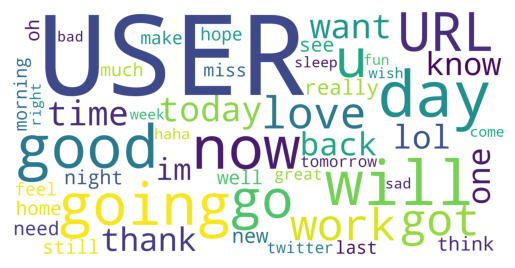

In [33]:
wordcloud = WordCloud(background_color='white',
                      width=1600,
                      height=800, 
                      collocations=False,
                      max_words=50).generate(corpus)
plt.imshow(wordcloud)
plt.axis("off")
plt.show();

In [ ]:
bad_corpus = " ".join([" ".join(tweet) for tweet in tweets_df[tweets_df.label==0].tokens])

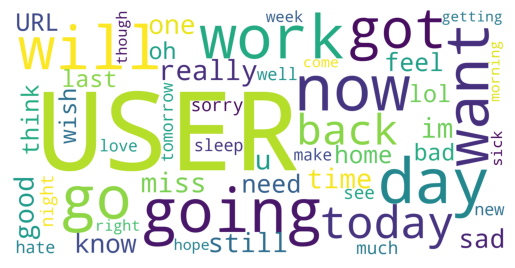

In [34]:
wordcloud = WordCloud(background_color='white',
                      width=1600,
                      height=800,
                      collocations=False,
                      max_words=50).generate(bad_corpus)
plt.imshow(wordcloud)
plt.axis("off")
plt.show();

In [ ]:
good_corpus = " ".join([" ".join(tweet) for tweet in tweets_df[tweets_df.label==1].tokens])

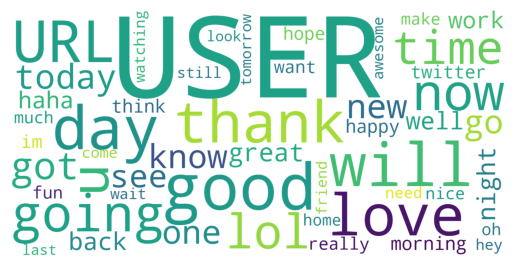

In [35]:
wordcloud = WordCloud(background_color='white',
                      width=1600,
                      height=800,
                      collocations=False,
                      max_words=50).generate(good_corpus)
plt.imshow(wordcloud)
plt.axis("off")
plt.show();

## Export/Import dataset

In [36]:
PROJECT_PATH = os.getcwd()[2:]
PROJECT_PATH = PROJECT_PATH.replace("\\", "/") + '/'

In [37]:
DATA_PATH = 'data/2_preprocessed/'
full_path = urljoin(PROJECT_PATH, DATA_PATH)
full_path

'/Users/USER/PycharmProjects/2_OC_IA/sentiment_analysis/src/data/2_preprocessed/'

In [39]:
if not os.path.exists(full_path):
    os.makedirs(full_path)

In [ ]:
df_file = 'tweets_df_' + str(tweets_df.shape[0])
df_file

with open(urljoin(full_path, df_file), 'wb') as f:
    pickle.dump(tweets_df, f)

### Test de l'export

In [50]:
ul_file = 'tweets_df_1600000'   #'tweets_df_1596630'

In [47]:
with open(urljoin(full_path, ul_file), mode='rb') as f:
    tweets_df = pickle.load(f)

In [48]:
tweets_df.sample(5)

,label,text,tokens_stem,tokens_lem
230675,0,@prince_son awww; No.,"[user, aww]","[USER, aww]"
965168,1,@RickGriffin TY for that wonderful #followfrid...,"[user, ty, wonder, followfriday, bro]","[USER, ty, wonderful, followfriday, bro]"
1434113,1,@BeauBain Thanks,"[user, thank]","[USER, thanks]"
885240,1,@crusaderz4life awww you are so sweet to send ...,"[user, aww, sweet, send, tweet, treat]","[USER, aww, sweet, send, tweet, treat]"
812241,1,@Sharagon77 Siiiii,"[user, sii]","[USER, sii]"


In [49]:
tweets_df.shape

(1600000, 4)

## Brouillon

In [44]:
mistakes_words = ['shes', 'shouldve', 'thatll', 'youd', 'youll', 'youre', 'youve']

abbreviations = {
    'u': 'you', 'r': 'are', 'some1': 'someone', 'yrs':'years',
    'hrs': 'hours', 'mins': 'minutes', 'secs': 'seconds',
    'pls': 'please', 'plz': 'please', '2morow': 'tomorrow',
    '2day': 'today', '4got': 'forget', '4gotten': 'forget',
    'hahah': 'haha','hahaha': 'haha','hahahaha': 'haha',
    "mother's": "mother", "mom's": "mom", "dad's":"dad",
    'bday': 'birthday', 'b-day': 'birthday',
}